In [209]:
import numpy as np
import matplotlib.pyplot as plt 
from PIL import Image
from PIL import ImageFilter
from scipy import ndimage
import cv2

import cPickle

from sklearn import linear_model, datasets

%matplotlib inline
one=cv2.imread("Images/Q2/Working set/I1.jpg")
two=cv2.imread("Images/Q2/Working set/I2.jpg")
three=cv2.imread("Images/Q2/Working set/I3.jpg")

In [210]:
def extract_features(img):
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    brisk=cv2.BRISK()
    kps,descs=brisk.detectAndCompute(gray,None)
    return (kps,descs)

def match_kp(descs1,descs2):
    matcher = cv2.DescriptorMatcher_create("BruteForce")
    rawMatches = matcher.knnMatch(descs1, descs2, 2)
    matches = []
    for m in rawMatches:
        if len(m) == 2 and m[0].distance < m[1].distance * .75:
            matches.append((m[0].trainIdx, m[0].queryIdx))
    return matches

def calc_H(matches,kp1,kp2):
    ptsA = np.float32([kp1[i].pt for (_, i) in matches])
    ptsB = np.float32([kp2[i].pt for (i, _) in matches])
    (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
        3)
    return H

def plop(H,one,two):
    ones=np.array([1,1,1])
    x_shift=abs(np.dot(H,ones)[0])
    trans=np.array([[1,0,x_shift],[0,1,0],[0,0,1]])
    result = cv2.warpPerspective(one, np.dot(H,trans),(one.shape[1] + two.shape[1], one.shape[0]))
    warp1=result.copy()
    result[0:two.shape[0], x_shift:two.shape[1]+x_shift] = two
    return result

def stitch(one,two):
    kps1,descs1=extract_features(one)
    kps2,descs2=extract_features(two)
    matches=match_kp(descs1,descs2)
    H=calc_H(matches,kp1,kp2)
    print(H)
    result=plop(H,one,two)
    return result

def autocrop(img):
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    non_empty_columns = np.where(gray.max(axis=0)>0)[0]
    non_empty_rows = np.where(gray.max(axis=1)>0)[0]
    cropBox = (min(non_empty_rows), max(non_empty_rows), min(non_empty_columns), max(non_empty_columns))
    return img[cropBox[0]:cropBox[1]+1, cropBox[2]:cropBox[3]+1 , :]

[[  6.75047231e-01  -2.03367803e+00   3.93034917e+02]
 [  5.87186396e-01  -1.84574610e+00   3.74743026e+02]
 [  1.53539839e-03  -4.88061855e-03   1.00000000e+00]]


/home/brendan/.local/lib/python2.7/site-packages/ipykernel/__main__.py:29: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


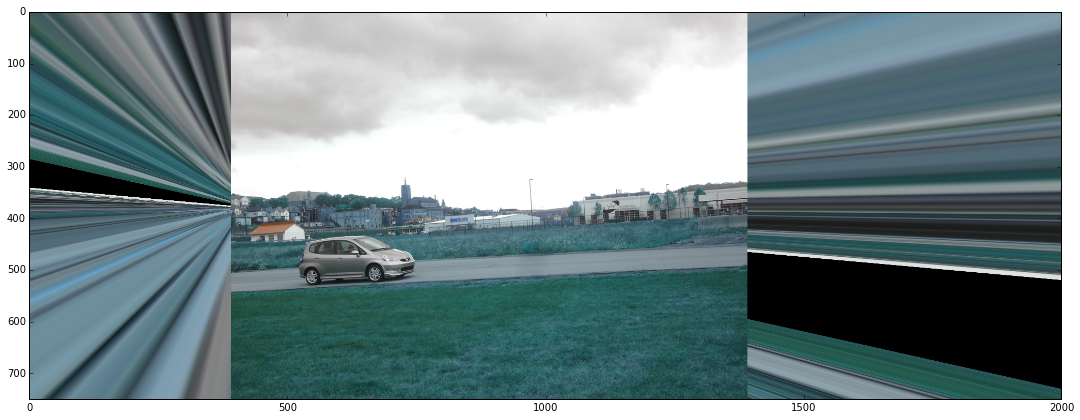

In [211]:
# autocrop(one)
result=stitch(two,three)
result=autocrop(result)
f2=plt.figure()
f2.set_size_inches(18.5, 10.5)
plt.imshow(result)



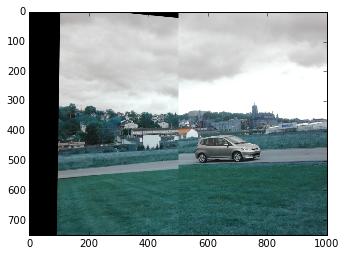

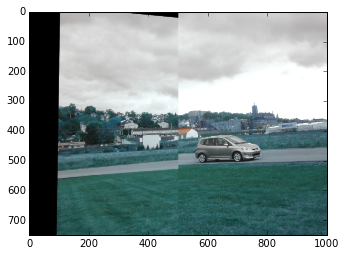

In [196]:
A=warp1.copy()
B=two.copy()

n=2
G = A.copy()
gpA = [G]
for i in xrange(n):
    G = cv2.pyrDown(G)
    gpA.append(G)

# generate Gaussian pyramid for B
G = B.copy()
gpB = [G]
for i in xrange(n):
    G = cv2.pyrDown(G)
    gpB.append(G)

# generate Laplacian Pyramid for A
lpA = [gpA[n-1]]
for i in xrange(n-1,0,-1):
    GE = cv2.pyrUp(gpA[i])
    L = cv2.subtract(gpA[i-1],GE)
    lpA.append(L)

# generate Laplacian Pyramid for B
lpB = [gpB[n-1]]
for i in xrange(n-1,0,-1):
    GE = cv2.pyrUp(gpB[i])
    L = cv2.subtract(gpB[i-1],GE)
    lpB.append(L)

    
# Now add left and right halves of images in each level
LS = []
for la,lb in zip(lpA,lpB):
    rows,cols,dpt = la.shape
    ls = np.hstack((la[:,0:cols/4], lb[:,cols/4:]))
    LS.append(ls)

# now reconstruct
ls_ = LS[0]
for i in xrange(1,n):
    ls_ = cv2.pyrUp(ls_)
    ls_ = cv2.add(ls_, LS[i])

# image with direct connecting each half
real = np.hstack((A[:,:cols/4],B[:,cols/4:]))
plt.figure()
plt.imshow(real)
plt.figure()
plt.imshow(ls_)